# Chapter 9: Markov Chain Monte Carlo - Samples

## 9.1 Good King Markov and his island kingdom

In [1]:
# Code 9.1
import numpy as np

num_weeks = 10_000
positions = np.repeat(0, num_weeks)
current = 10
for i in range(num_weeks):
    ## record current position
    positions[i] = current
    ## flip coin to generate proposal
    proposal = current + np.random.choice([-1, 1], 1)
    ## now make sure he loops around the archipelago
    proposal = 10 if proposal < 1 else proposal
    proposal = 1 if proposal > 10 else proposal
    ## move?
    prob_move = proposal / current
    current = proposal if np.random.uniform(0, 1) < prob_move else current

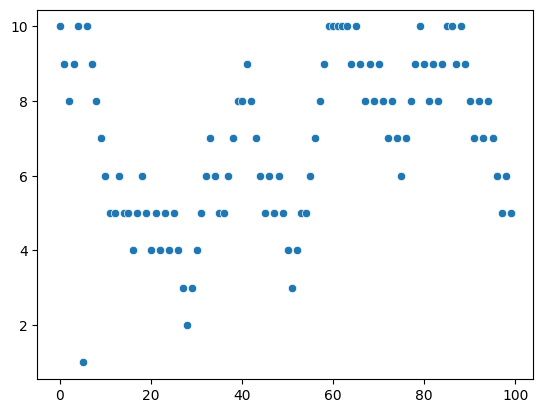

In [2]:
# Code 9.2
import seaborn as sns

sns.scatterplot(x=np.arange(100), y=positions[:100]);

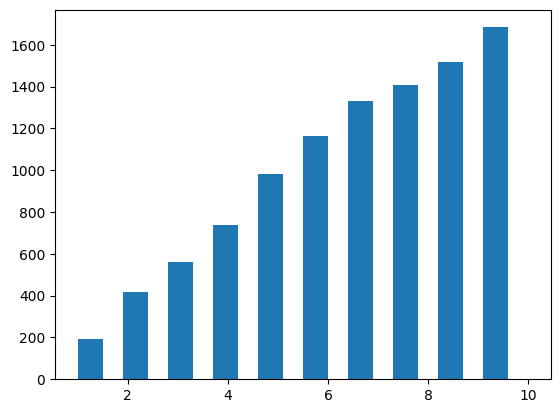

In [6]:
# Code 9.3
from matplotlib import pyplot as plt
plt.hist(positions, width=0.5);

## 9.2 Metropolis algorithms

### 9.2.1 Gibbs sampling

### 9.2.2 High-dimensional problems

(0.0, 40.0)

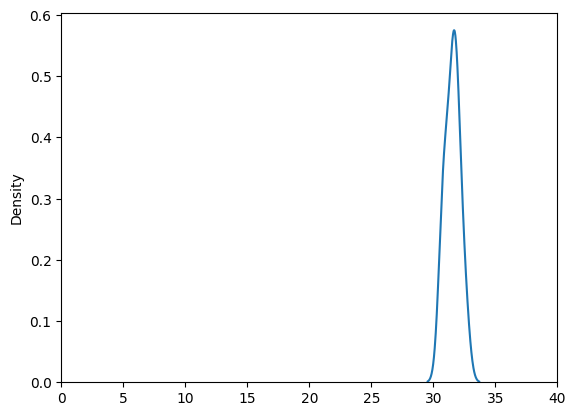

In [8]:
# Code 9.4
from matplotlib import pyplot as plt

D = 10
T = 1_000
Y = np.random.multivariate_normal(mean=np.repeat(0, D), cov=np.identity(D), size=T)
Rd = np.sqrt((Y**2).sum(axis=0))
sns.kdeplot(Rd)
plt.xlim(0,40)

## 9.3 Hamiltonian Monte Carlo

### 9.3.1 Another parable

### 9.3.2 Particles in space

In [9]:
# Code 9.5
from scipy import stats

# U needs to return neg-log-probability

def U(q, y, x, a=0, b=1, k=0, d=1):
    muy = q[0]
    mux = q[1]
    u = (
        np.sum(stats.norm(loc=muy, scale=1).logpdf(y))
        + np.sum(stats.norm(loc=mux, scale=1).logpdf(x))
        + np.sum(stats.norm(loc=a, scale=b).logpdf(muy))
        + np.sum(stats.norm(loc=k, scale=d).logpdf(mux))
    )
    return -u

In [10]:
# Code 9.6
# gradient function
# need vectior of partial derivatives of U with respect to vector q
def U_gradient(q, y, x, a=0, b=1, k=0, d=1):
    muy = q[0]
    mux = q[1]
    G1 = sum(y - muy) + (a - muy)/b**2 #dU/dmuy
    G2 = sum(x - mux) + (k - mux)/d**2 #dU/dmuy
    return np.array([-G1, -G2]) # negative bc energy is neg-log-prob

# test data
np.random.seed(7)
y = np.random.normal(size=50)
x = np.random.normal(size=50)

In [11]:
# Code 9.8 - 9.10
def HMC2(U, grad_U, epsilon, L, current_q, x, y):
    q = current_q
    p = np.random.normal(size=len(q), loc=0, scale=1) # random flick - p is momentum
    current_p = p
    # Make a half step for momentum at the beginning
    p = p - epsilon * grad_U(q, y, x)  / 2
    # initialize bookkeeping - saves trajectory
    qtraj = np.empty((L+2, len(q)))
    ptraj = qtraj.copy()
    qtraj[0, :] = current_q
    ptraj[0, :] = p
    
    
    # Alternate full steps for position and momentum
    for i in range(L):
        q = q + epsilon * p
        # Make a full step for the momentum, except at the end of trajectory
        if i != L:
            p = p - epsilon * grad_U(q, y, x)
            ptraj[i+1, :] = p
        qtraj[i+1, :] = q
        
    
    # Make a half step for momentum at the end
    p = p - epsilon * grad_U(q, y, x) / 2
    ptraj[L+1, :] = p
    # Negate momentum at end of trajectory to make the proposal symmetric
    p = -p
    # Evaluate potential and kinetic energies at start and end of trajectory
    current_U = U(current_q, y, x)
    current_K = np.sum(current_p**2) / 2
    proposed_U = U(q, y, x)
    proposed_K = np.sum(p**2) / 2
    # Accept ot reject the state at end of trajectory, returning either
    # the position at the end of the trajectory or the initial position
    accept = 0
    if np.random.uniform(0, 1, size=1)[0] < np.exp(current_U - proposed_U + current_K - proposed_K):
        new_q = q # accept
        accept = 1
    else:
        new_q = current_q # reject
    return dict(q=new_q, traj=qtraj, ptraj=ptraj, accept=accept)

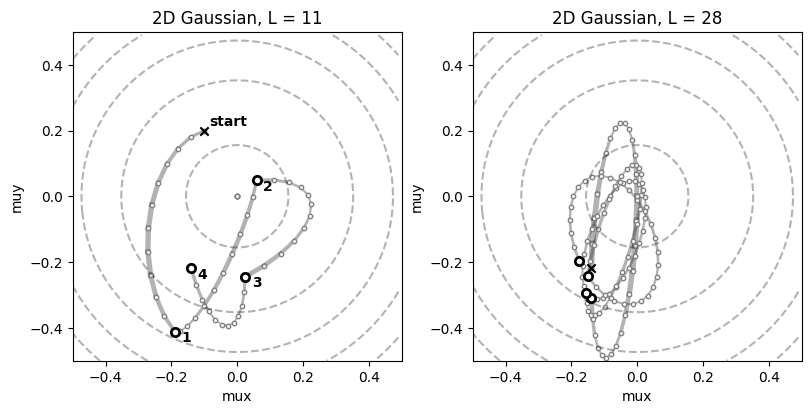

In [12]:
# Code 9.7
np.random.seed(42)

# test data
real = stats.multivariate_normal([0, 0], np.identity(2))
x, y = real.rvs(50).T

Q = {}
Q["q"] = np.array([-0.1, 0.2])
pr = 0.5
step = 0.03
# L = 11  # 0.03 / 28 for U-turns -- 11 for working example
n_samples = 4

_, axs = plt.subplots(1, 2, figsize=[8, 6], constrained_layout=True)

for L, ax in zip([11, 28], axs):
    ax.scatter(*Q["q"], color="k", marker="x", zorder=3)
    if L == 11:
        ax.text(*Q["q"] + 0.015, "start", weight="bold")
    for i in range(n_samples):
        Q = HMC2(U, U_gradient, step, L, Q["q"], x, y)
        ax.scatter(*Q["q"], color="w", marker="o", edgecolor="k", lw=2, zorder=3)
        if n_samples < 10:
            for j in range(L):
                K0 = np.sum(Q["ptraj"][j, :] ** 2) / 2  # kinetic energy
                ax.plot(
                    Q["traj"][j : j + 2, 0],
                    Q["traj"][j : j + 2, 1],
                    color="k",
                    lw=1 + 1 * K0,
                    alpha=0.3,
                    zorder=1,
                )
            ax.scatter(*Q["traj"].T, facecolor="w", edgecolor="gray", lw=1, zorder=2, s=10)
            if L == 11:
                ax.text(*Q["q"] + [0.02, -0.03], f"{i + 1}", weight="bold")

    ax.set_title(f"2D Gaussian, L = {L}")
    ax.set_xlabel("mux")
    ax.set_ylabel("muy")

    # draw background contours based on real probability defined above
    ax.set_xlim(-pr, pr)
    ax.set_ylim(-pr, pr)
    xs, ys = np.mgrid[-pr:pr:0.01, -pr:pr:0.01]
    p = real.logpdf(np.vstack([xs.flat, ys.flat]).T).reshape(xs.shape)
    ax.contour(xs, ys, p, 4, colors=[(0, 0, 0, 0.3)])
    ax.set_aspect(1);

### 9.3.3 Limitations

## 9.4 Easy HMC: `ulam`

In [13]:
# Code 9.11
import pandas as pd
from rethinking import DATA_PATH

d = pd.read_csv(DATA_PATH.joinpath('rugged.csv'), sep=';')
d['log_gdp'] = np.log(d['rgdppc_2000'])

dd = d.dropna(subset=['log_gdp'])
log_gdp_std = dd['log_gdp'] / dd['log_gdp'].mean()
rugged_std = dd['rugged'] / dd['rugged'].max()
cid = np.where(dd['cont_africa'] == 1, 0, 1)

In [14]:
# Code 9.12
from rethinking import precis, quap
import pymc as pm

with pm.Model() as model:
    a = pm.Normal('a', 1, 0.1, shape=2)
    b = pm.Normal('b', 0, 0.3, shape=2)
    sigma = pm.Exponential('sigma', 1)
    mu = a[cid] + b[cid] * (rugged_std - 0.215)
    gdp_result = pm.Normal('gdp_result', mu, sigma, observed=log_gdp_std)
    post83, vars_ = quap(model)
    trace83 = pm.sample()

precis(post83, ['a1', 'a2', 'b1', 'b2', 'sigma'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


,mean,std,5.5%,94.5%
a1,0.886640,0.015633,0.861862,0.911446
a2,1.050560,0.009836,1.034738,1.065999
b1,0.132468,0.075336,0.012416,0.252686
b2,-0.142132,0.054423,-0.228655,-0.054479
sigma,0.110276,0.054676,0.022118,0.197081


### 9.4.1 Preparation

In [17]:
# Code 9.13 - 9.18
dat_slim = {
    'n': len(cid),
    'log_gdp_std': list(log_gdp_std),
    'rugged_std': list(rugged_std),
    'cid': list(cid + 1)
}

### 9.4.2 Sampling from the posterior

In [19]:
import nest_asyncio
nest_asyncio.apply()
import stan
import arviz as az

rugged_code = """
data {
  int<lower=1> n;        // number of observations
  vector[n] log_gdp_std; // outcome
  vector[n] rugged_std;  // regressor
  array[n] int cid;         // regressor
}
parameters {
  real<lower=0> sigma;
  vector[2] a;
  vector[2] b;
}
model {
  vector[n] mu;
  for (i in 1:n) {
    mu[i] = a[cid[i]] + b[cid[i]] * (rugged_std[i] - 0.215);
  }
  a ~ normal(1, 0.1);
  b ~ normal(0, 0.3);
  sigma ~ exponential(1);
  log_gdp_std ~ normal(mu, sigma);
}
"""

posterior = stan.build(rugged_code, data=dat_slim)
fit = posterior.sample(num_chains=2, num_samples=1000)

idata = az.from_pystan(posterior=fit, posterior_model=posterior)
az.summary(idata, kind="all", round_to=2)

Building: found in cache, done.
Sampling:   0%
Sampling:  50% (2000/4000)
Sampling: 100% (4000/4000)
Sampling: 100% (4000/4000), done.
Messages received during sampling:
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/04/m78thc1d1sd9y0q4b5v6fb6r0000gn/T/httpstan_j6reizcl/model_5qqba4la.stan', line 21, column 2 to column 34)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Gradient evaluation took 1.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.11,0.01,0.10,0.12,0.0,0.0,2297.88,1559.08,1.0
a[0],0.89,0.02,0.86,0.92,0.0,0.0,2457.82,1486.48,1.0
a[1],1.05,0.01,1.03,1.07,0.0,0.0,2463.52,1477.45,1.0
b[0],0.14,0.07,-0.01,0.27,0.0,0.0,2097.00,1480.03,1.0
b[1],-0.14,0.06,-0.25,-0.03,0.0,0.0,1808.34,1230.00,1.0


### 9.4.3 Sampling again, in parallel

### 9.4.4 Visualization

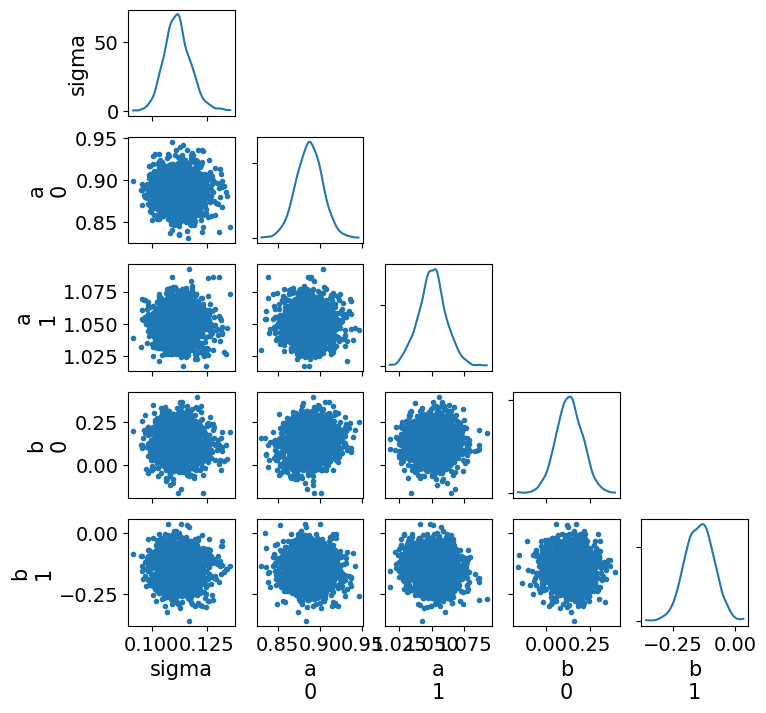

In [125]:
# Code 9.19
az.plot_pair(idata, figsize=[8, 8], marginals=True);

### 9.4.5 Checking the chain

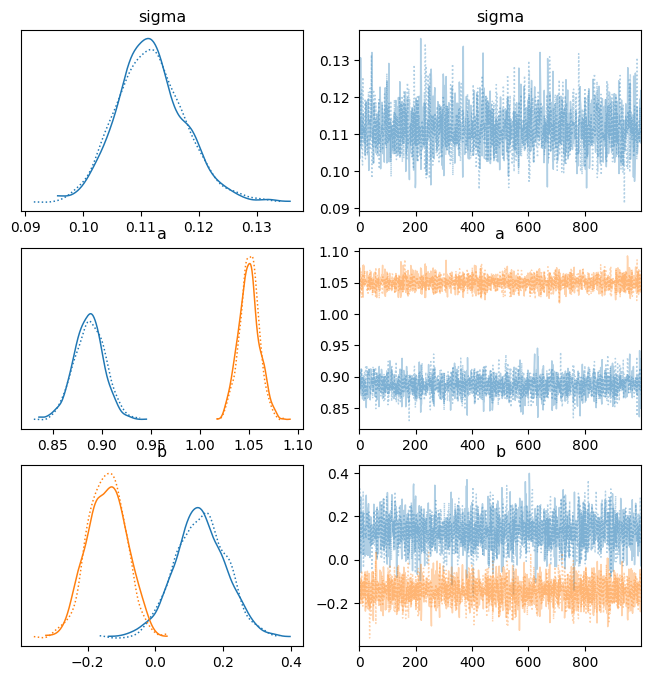

In [126]:
az.plot_trace(idata, figsize=[8, 8]);

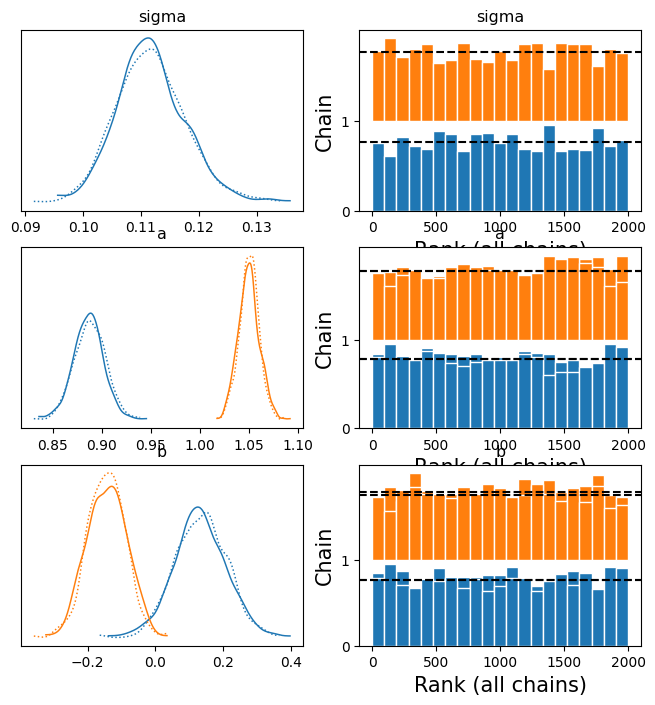

In [127]:
az.plot_trace(idata, figsize=[8, 8], kind="rank_bars");

## 9.5 Care and feeding of your Markov Chain

### 9.5.1 How many samples do you need?

### 9.5.2 How many chains to you need?

### 9.5.3 Taming a wild chain.

In [21]:
# Code 9.22 & 9.23
data = {'y': [-1, 1]}
code = """
data {
  real y[2]; // outcome
}
parameters {
  real<lower=0> sigma;
  real alpha;
}
model {
  real mu;
  alpha ~ normal(0, 1000);
  sigma ~ exponential(0.0001);
  mu = alpha;
  y ~ normal(mu, sigma);
}
"""

posterior = stan.build(code, data=data)
fit = posterior.sample(num_chains=3, num_samples=1000)

idata = az.from_pystan(posterior=fit, posterior_model=posterior)
az.summary(idata)

Building: 0.1s
Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s


In file included from /Users/gustavo-sf/Library/Caches/httpstan/4.8.2/models/w6stb7os/model_w6stb7os.cpp:2:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:26:
/Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:70:32: warning: lambda capture 'b' is not use

Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s


In file included from /Users/gustavo-sf/Library/Caches/httpstan/4.8.2/models/w6stb7os/model_w6stb7os.cpp:2:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/prim/prob.hpp:128:
/Users/gustavo-sf/Librar

Building: 3.2s
Building: 3.3s
Building: 3.4s


In file included from /Users/gustavo-sf/Library/Caches/httpstan/4.8.2/models/w6stb7os/model_w6stb7os.cpp:2:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/prim/prob.hpp:312:
In file included from /U

Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s


In file included from /Users/gustavo-sf/Library/Caches/httpstan/4.8.2/models/w6stb7os/model_w6stb7os.cpp:2:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:98:
/Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/lb_constrain.hpp:114:33: warning: lambda capture 'lp' 

Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s


11 warnings generated.
ld: warning: -undefined dynamic_lookup may not work with chained fixups
Building: 6.5s, done.
Messages from stanc:
Warning in '/var/folders/04/m78thc1d1sd9y0q4b5v6fb6r0000gn/T/httpstan_8mmmf8_q/model_w6stb7os.stan', line 3, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/04/m78thc1d1sd9y0q4b5v6fb6r0000gn/T/httpstan_8mmmf8_q/model_w6stb7os.stan', line 12, column 22: Argument
    0.0001 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/04/m78thc1d1sd9y0q4b5v6fb6r0000gn/T/httpstan_8mmmf8_q/model_w6stb7os.stan', line 11, column 20: Argument
    1000 suggests there may be parameters that are not unit scale; consider
    rescaling with a m

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,478.979,1173.506,5.636,1898.115,125.450,89.004,9.0,16.0,1.26
alpha,35.145,333.632,-619.108,722.199,20.737,15.877,389.0,226.0,1.18


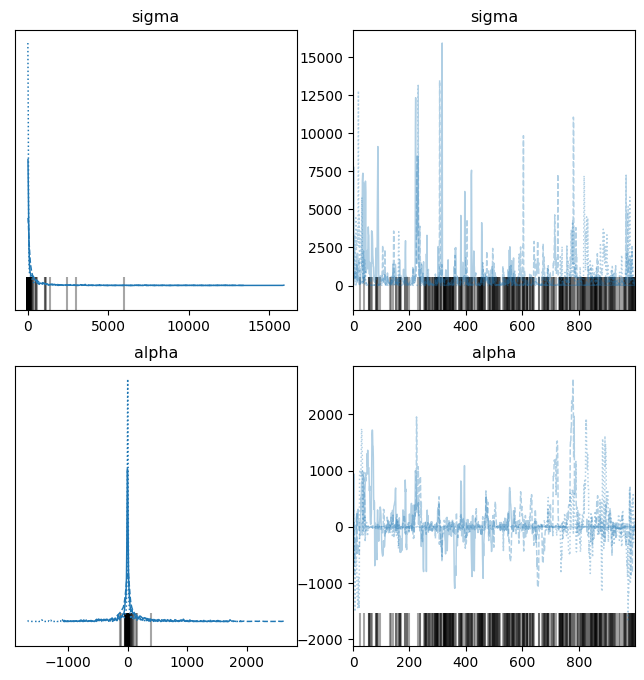

In [22]:
az.plot_trace(idata, figsize=[8, 8]);

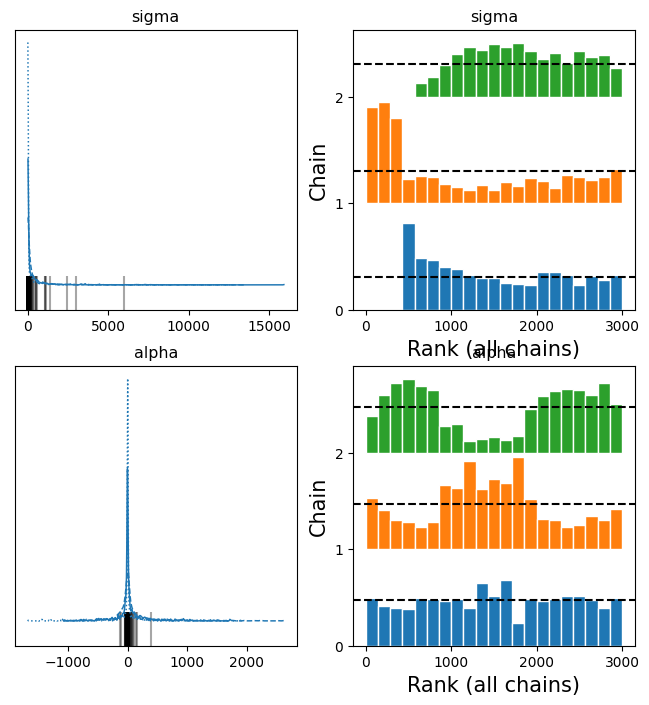

In [23]:
az.plot_trace(idata, figsize=[8, 8], kind="rank_bars");

In [24]:
# Code 9.24
code = """
data {
  real y[2]; // outcome
}
parameters {
  real<lower=0> sigma;
  real alpha;
}
model {
  real mu;
  alpha ~ normal(1, 10);
  sigma ~ exponential(1);
  mu = alpha;
  y ~ normal(mu, sigma);
}
"""

posterior = stan.build(code, data=data)
fit = posterior.sample(num_chains=3, num_samples=1000)

idata = az.from_pystan(posterior=fit, posterior_model=posterior)
az.summary(idata)

Building: 0.1s
Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s


In file included from /Users/gustavo-sf/Library/Caches/httpstan/4.8.2/models/25nn3aoj/model_25nn3aoj.cpp:2:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:26:
/Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:70:32: warning: lambda capture 'b' is not use

Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s


In file included from /Users/gustavo-sf/Library/Caches/httpstan/4.8.2/models/25nn3aoj/model_25nn3aoj.cpp:2:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/prim/prob.hpp:128:
/Users/gustavo-sf/Librar

Building: 2.9s
Building: 3.0s


In file included from /Users/gustavo-sf/Library/Caches/httpstan/4.8.2/models/25nn3aoj/model_25nn3aoj.cpp:2:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/prim/prob.hpp:312:
In file included from /U

Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s


In file included from /Users/gustavo-sf/Library/Caches/httpstan/4.8.2/models/25nn3aoj/model_25nn3aoj.cpp:2:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:98:
/Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/lb_constrain.hpp:114:33: warning: lambda capture 'lp' 

Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s


11 warnings generated.
ld: warning: -undefined dynamic_lookup may not work with chained fixups
Building: 6.1s, done.
Messages from stanc:
Warning in '/var/folders/04/m78thc1d1sd9y0q4b5v6fb6r0000gn/T/httpstan_meg_cj_r/model_25nn3aoj.stan', line 3, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Sampling:   0%
Sampling:  33% (2000/6000)
Sampling:  67% (4000/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 1.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.18 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.04 seconds.
  Adjust your expectations accordingly!
 

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,1.561,0.836,0.493,3.107,0.030,0.021,844.0,1149.0,1.0
alpha,0.002,1.206,-2.322,2.236,0.042,0.034,932.0,828.0,1.0


### 9.5.4 Non-identifiable parameters

In [26]:
# Code 9.25
y = np.random.normal(size=100, loc=0, scale=1)

In [27]:
# Code 9.26
data = {'y': list(y)}
code = """
data {
  real y[100]; // outcome
}
parameters {
  real<lower=0> sigma;
  real a1;
  real a2;
}
model {
  real mu;
  a1 ~ normal(0, 1000);
  a2 ~ normal(0, 1000);
  sigma ~ exponential(1);
  mu = a1 + a2;
  y ~ normal(mu, sigma);
}
"""

posterior = stan.build(code, data=data)
fit = posterior.sample(num_chains=3, num_samples=1000)

idata = az.from_pystan(posterior=fit, posterior_model=posterior)
az.summary(idata)

Building: 0.1s
Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s


In file included from /Users/gustavo-sf/Library/Caches/httpstan/4.8.2/models/2bw3n7iu/model_2bw3n7iu.cpp:2:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:26:
/Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:70:32: warning: lambda capture 'b' is not use

Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s


In file included from /Users/gustavo-sf/Library/Caches/httpstan/4.8.2/models/2bw3n7iu/model_2bw3n7iu.cpp:2:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/prim/prob.hpp:128:
/Users/gustavo-sf/Librar

Building: 2.8s
Building: 2.9s


In file included from /Users/gustavo-sf/Library/Caches/httpstan/4.8.2/models/2bw3n7iu/model_2bw3n7iu.cpp:2:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/prim/prob.hpp:312:
In file included from /U

Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s


In file included from /Users/gustavo-sf/Library/Caches/httpstan/4.8.2/models/2bw3n7iu/model_2bw3n7iu.cpp:2:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:98:
/Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/lb_constrain.hpp:114:33: warning: lambda capture 'lp' 

Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s


11 warnings generated.
ld: warning: -undefined dynamic_lookup may not work with chained fixups
Building: 6.1s, done.
Messages from stanc:
Warning in '/var/folders/04/m78thc1d1sd9y0q4b5v6fb6r0000gn/T/httpstan_2om_1pid/model_2bw3n7iu.stan', line 3, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/04/m78thc1d1sd9y0q4b5v6fb6r0000gn/T/httpstan_2om_1pid/model_2bw3n7iu.stan', line 13, column 17: Argument
    1000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/04/m78thc1d1sd9y0q4b5v6fb6r0000gn/T/httpstan_2om_1pid/model_2bw3n7iu.stan', line 12, column 17: Argument
    1000 suggests there may be parameters that are not unit scale; consider
    rescaling with a mul

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.973,0.061,0.861,1.109,0.010,0.007,42.0,79.0,1.02
a1,-48.841,540.919,-1109.067,933.547,286.967,222.388,4.0,11.0,2.36
a2,48.881,540.919,-933.506,1109.159,286.968,222.388,4.0,11.0,2.36


In [28]:
# Code 9.27
data = {'y': list(y)}
code = """
data {
  real y[100]; // outcome
}
parameters {
  real<lower=0> sigma;
  real a1;
  real a2;
}
model {
  real mu;
  a1 ~ normal(0, 10);
  a2 ~ normal(0, 10);
  sigma ~ exponential(1);
  mu = a1 + a2;
  y ~ normal(mu, sigma);
}
"""

posterior = stan.build(code, data=data)
fit = posterior.sample(num_chains=3, num_samples=1000)

idata = az.from_pystan(posterior=fit, posterior_model=posterior)
az.summary(idata)

Building: 0.1s
Building: 0.2s
Building: 0.3s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s


In file included from /Users/gustavo-sf/Library/Caches/httpstan/4.8.2/models/kmhaep4g/model_kmhaep4g.cpp:2:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:26:
/Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:70:32: warning: lambda capture 'b' is not use

Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s


In file included from /Users/gustavo-sf/Library/Caches/httpstan/4.8.2/models/kmhaep4g/model_kmhaep4g.cpp:2:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/prim/prob.hpp:128:
/Users/gustavo-sf/Librar

Building: 2.7s
Building: 2.8s


In file included from /Users/gustavo-sf/Library/Caches/httpstan/4.8.2/models/kmhaep4g/model_kmhaep4g.cpp:2:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/prim/prob.hpp:312:
In file included from /U

Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s


In file included from /Users/gustavo-sf/Library/Caches/httpstan/4.8.2/models/kmhaep4g/model_kmhaep4g.cpp:2:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:98:
/Users/gustavo-sf/Library/Caches/pypoetry/virtualenvs/rethinking-jYLlN9nu-py3.10/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/lb_constrain.hpp:114:33: warning: lambda capture 'lp' 

Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s


11 warnings generated.
ld: warning: -undefined dynamic_lookup may not work with chained fixups
Building: 5.8s, done.
Messages from stanc:
Warning in '/var/folders/04/m78thc1d1sd9y0q4b5v6fb6r0000gn/T/httpstan_f7gn29q7/model_kmhaep4g.stan', line 3, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Sampling:   0%
Sampling:   5% (300/6000)
Sampling:  10% (600/6000)
Sampling:  17% (1000/6000)
Sampling:  27% (1600/6000)
Sampling:  55% (3300/6000)
Sampling:  82% (4900/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 6e-06 seconds
  1000 transitions

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.981,0.071,0.857,1.116,0.002,0.002,1190.0,955.0,1.01
a1,0.415,6.791,-12.524,12.346,0.247,0.175,756.0,1081.0,1.00
a2,-0.379,6.791,-12.088,12.693,0.247,0.174,756.0,1081.0,1.00


## Summary

Informal introduction to Markov Chain Monte Carlo (MCMC) estimation.
1. Metropolis
2. Gibbs sampling
3. Hamiltonian Monte Carlo

Introduced advice on diagnosing poor MCMC fits.